In [138]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [139]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [140]:
import arrow
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#plt.style.use('classic')
from matplotlib.patches import Rectangle
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc
import sys
sys.path.append('../pyscripts/bylayer_extract/')
import extract_bylayer_mean_BOXMASK as ebmBOX 
from importlib import reload
from salishsea_tools import viz_tools

import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

%matplotlib inline
warnings.simplefilter('ignore')

# plt.rcParams.update({'font.size': 13,
#                      'xtick.labelsize' : 13,
#                      'ytick.labelsize' : 13})

#### LOAD GLOPAP 
####  take relevant parts of dataframe and make arrays
#### CONVERT DIC AND TA FROM UMOL/KG TO MMOL/M3

In [141]:
import pandas as pd

#df = pd.read_csv('../KEY_OTHER_ESTUARIES/data_papers/GLODAPv2.2019_Merged_Master_File.csv')
df = pd.read_csv('../KEY_OTHER_ESTUARIES/data_papers/GLODAPv2.2020_Merged_Master_File.csv')

# data_top = list(df.columns) 
# print(data_top)

In [142]:
#need - bottom depth, pressure, dic, ta, salinity, temp, lat, lon
tALK = np.array(df['talk'][:])
tALK_orig = np.copy(tALK)
tDIC = np.array(df['tco2'][:])
tDIC_orig = np.copy(tDIC)
tSAL = np.array(df['salinity'][:])
tTEMP = np.array(df['temperature'][:])
tPRES = np.array(df['pressure'][:])
tLAT = np.array(df['latitude'][:])
tLON = np.array(df['longitude'][:])
tBOTdepth = np.array(df['bottomdepth'][:])
tYEAR = np.array(df['year'])
tOXY = np.array(df['oxygen'])
#tAOU = np.array(df['aou'][:])

#convert from umol/kg to mmol/m3
import seawater
dens = seawater.dens(tSAL,tTEMP,tPRES)
tDIC=tDIC*dens/1000
tALK=tALK*dens/1000

tALK_DIC = tALK-tDIC
tALK_DIC2 = tALK-(tDIC+50)

tpcfc11 = np.array(df['pcfc11'][:])
tpcfc12 = np.array(df['pcfc12'][:])
tpsf6 = np.array(df['psf6'][:])

In [143]:
### egleston calculations
def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A

# t_omega_DIC, t_beta_DIC, t_gammaDIC, t_OmegaA_A = \
# calculate_Egleston_factors\
# (tTEMP, tSAL, tALK*1e-3, tDIC*1e-3, tPRES, 0.01)



def calculate_Egleston_factors_tPOT(ttemp, tsal, talk, tdic_A, dep, del_dic):

    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A



##### filters - TA and DIC, TEMP, SAL should exist, depth < 500, TA-DIC conditions, etc, filt_comp is a comprehensive filter of everything


In [144]:
#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-999) & (~np.isnan(tTEMP))
filt_PRES = (tPRES >-999) & (~np.isnan(tPRES))
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)
filt_OXY = (tOXY > -999) & (~np.isnan(tOXY))
#filt_AOU = (tAOU>-999) & (~np.isnan(tAOU))
filt_YEAR = (tYEAR > 2000)
#bottom depth relatively shallow <
filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
#year is modern
filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL

# filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & filt_TEMP & filt_DIC & filt_ALK

filt_comp = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR #& filt_AOU



filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC2 = (np.abs(tALK_DIC2) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)

filt_cfc = (((tpcfc11>-999) & (~np.isnan(tpcfc11))) | \
               ((tpcfc12>-999) & (~np.isnan(tpcfc12))) | \
               ((tpsf6>-999) & (~np.isnan(tpsf6))) )

filt_comp_cfc = filt_DEPTH2& filt_EST & filt_PRES & filt_SAL & \
filt_TEMP & filt_DIC & filt_ALK  & filt_YEAR & filt_cfc & filt_OXY


# print('total_datapoints with DIC measurements')
# print(np.shape(filt_DIC))
# print('total datapoints with our filt-comp')
# print(np.shape(np.where(filt_comp)))
# print('total datapoints with our filt-comp-cfc')
# print(np.shape(np.where(filt_comp_cfc)))
# print('total datapoints with our filt-comp with abs(TA-DIC)<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC)))
# print('total datapoints with our filt-comp with abs(TA-(DIC+50))<50')
# print(np.shape(np.where(filt_comp&filt_ALK_DIC2)))

In [145]:
###### manually assign geolocations
tGEO = np.zeros_like(tBOTdepth)

#canadian arctic
westlon = -148; eastlon = -50; southlat = 60; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 1

#euro arctic
westlon = -30; eastlon = 91; southlat = 70; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 2
#atlantic 1
westlon = -50; eastlon = 30; southlat = 0; northlat = 70
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#atlantic 2
westlon = -100; eastlon = -50; southlat = 0; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#siberian arctic
westlon = 91; eastlon = 180; southlat = 68; northlat = 91
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 4
#pacific coast
westlon = -140; eastlon = -100; southlat = 10; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 5
#Russian-Alaskan Interface
westlon = -180; eastlon = -148; southlat = 50; northlat = 90
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 6
#Kamchatka Region
westlon = 120; eastlon = 180; southlat = 48; northlat = 68
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 7
#Japan and China
westlon = 120; eastlon = 180; southlat = 10; northlat = 48
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 8
#SO
westlon = -180; eastlon = 180; southlat = -90; northlat = -60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 9

In [146]:
PLACES_withdat = {
'Canadian Arctic': { 'geodat': 1, 'colour': 'blueviolet', 'name':'Canadian Arctic'},
'European Arctic': { 'geodat': 2, 'colour': 'darkorange', 'name':'European Arctic'},
'N. Atlantic': { 'geodat': 3, 'colour': 'red', 'name':'N. Atlantic'},
'Siberian Arctic': { 'geodat': 4, 'colour': 'dodgerblue', 'name':'Siberian Arctic'},
'Coastal Pacific': { 'geodat': 5, 'colour': 'blue', 'name':'Coastal Pacific'},
'Russian/Alaskan Interface': { 'geodat': 6, 'colour': 'skyblue', 'name':'Russian/Alaskan \n Interface'},
'Kamchatka Region': { 'geodat': 7, 'colour': 'lightsteelblue', 'name':'Kamchatka Region'},
'China/Japan': { 'geodat': 8, 'colour': 'steelblue', 'name':'China/Japan'},
'Southern Ocean': { 'geodat': 9, 'colour': 'green', 'name':'Southern Ocean'},
'Everything Else': { 'geodat': 0, 'colour': 'grey', 'name':'Everything Else'},
}

list_places = ['Everything Else','Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',]

print(list_places)


['Everything Else', 'Canadian Arctic', 'European Arctic', 'N. Atlantic', 'Siberian Arctic', 'Coastal Pacific', 'Russian/Alaskan Interface', 'Kamchatka Region', 'China/Japan', 'Southern Ocean']


# PLOT AVAILABLE COASTAL OBSERVATIONS IN DIC/TA SPACE...

It's unsurprisingly a bit of a mess. But even plotting means with DIC and TA std. devs. could be relevant? tells more of a story.

Text(0.5, 0.98, 'Coastal observations in DIC/TA space')

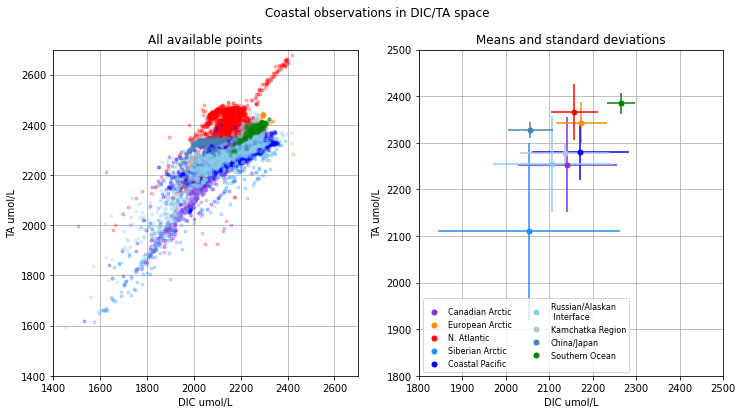

In [147]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(20*fact,10*fact))
ax = plt.subplot(1,2,1)
fs = 8
tcol = 'black'
tlw = 4.5

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
            tALK[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)
ax.grid()
ax.set_xlim([1400,2700])
ax.set_ylim([1400,2700])

ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')    
ax.set_title('All available points')

ax = plt.subplot(1,2,2)
fs = 8
tcol = 'black'
tlw = 4.5
ms = 10

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)
    ax.errorbar(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
                np.nanmean(tALK[filt_comp & (tGEO == geotag)]), \
                xerr = np.nanstd(tDIC[filt_comp & (tGEO == geotag)]),\
                yerr = np.nanstd(tALK[filt_comp & (tGEO == geotag)]),
                fmt="o",
               color = tcol, marker = '.', linestyle = '',\
            alpha = 1)
ax.legend(ncol = 2, loc = 'best', fontsize = 8)
ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

plt.suptitle('Coastal observations in DIC/TA space')


### calculate factors! 

In [148]:
#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 
tcmap = cm.thermal

#salinity 0-35
#
S = np.zeros([130,130])
T = np.zeros([130,130])
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

S[:] = 30
T[:] = 10

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i


DIC_ar = DIC[0,:]
TA_ar = TA[:,0]  
    
Sr = np.ravel(S)
Tr = np.ravel(T)  
DICr = np.ravel(DIC) * 1e-3
TAr = np.ravel(TA) * 1e-3
del_dic = 10 * 1e-3
zero = DICr *0

response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

#def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
    #return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A
omega_DIC_r= omega_DIC.reshape(130,130)
OmegaA_A_r = OmegaA_A.reshape(130,130)

## do this for other S and T values

In [149]:
#salinity 30, temperature 10 , DIC AND TA vary from 1800 to 2200 
tcmap = cm.thermal

#salinity 0-35
#
S = np.zeros([130,130])
T = np.zeros([130,130])
TA = np.zeros([130,130])
DIC = np.zeros([130,130])

S[:] = 32
T[:] = 10

for i in range(0,130):
    DIC[:,i] = 1400 + 10*i
for i in range(0,130):
    TA[i,:] = 1400 + 10*i

DIC_ar = DIC[0,:]
TA_ar = TA[:,0]  
    
Sr = np.ravel(S)
Tr = np.ravel(T)  
DICr = np.ravel(DIC) * 1e-3
TAr = np.ravel(TA) * 1e-3
del_dic = 10 * 1e-3
zero = DICr *0

response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S32_T10= omega_DIC.reshape(130,130)
OmegaA_A_r_S32_T10 = OmegaA_A.reshape(130,130)
####
S[:] = 32
T[:] = 20


response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S32_T20= omega_DIC.reshape(130,130)
OmegaA_A_r_S32_T20 = OmegaA_A.reshape(130,130)

S[:] = 20
T[:] = 10
response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S20_T10= omega_DIC.reshape(130,130)
OmegaA_A_r_S20_T10 = OmegaA_A.reshape(130,130)

S[:] = 20
T[:] = 20
response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S20_T20= omega_DIC.reshape(130,130)
OmegaA_A_r_S20_T20 = OmegaA_A.reshape(130,130)

S[:] = 33
T[:] = 7
response_tup = mocsy.mvars(temp=Tr, sal=Sr, alk=TAr, dic=DICr, 
                       sil=zero, phos=zero, patm=zero+1, depth=zero, lat=zero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH,pco2,fco2,co2_B,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

pHr_vTD = pH.reshape(130,130)
OmegaAr_vTD = OmegaA.reshape(130,130)

omega_DIC, beta_DIC, gamma_DIC, OmegaA_A = \
calculate_Egleston_factors(Tr, Sr, TAr, DICr, zero, del_dic)
omega_DIC_r_S33_T7= omega_DIC.reshape(130,130)
OmegaA_A_r_S33_T7 = OmegaA_A.reshape(130,130)


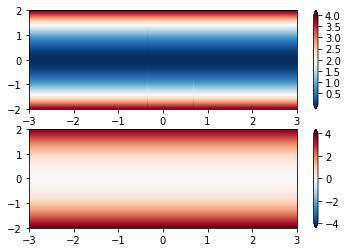

In [150]:
"""
Demonstration of using norm to map colormaps onto data in non-linear ways.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#from matplotlib.mlab import bivariate_normal

N = 100
'''
Custom Norm: An example with a customized normalization.  This one
uses the example above, and normalizes the negative data differently
from the positive.
'''
X, Y = np.mgrid[-3:3:complex(0, N), -2:2:complex(0, N)]
Z1 = Y**2
#Z1 = (bivariate_normal(X, Y, 1., 1., 1.0, 1.0))**2  \
#     - 0.4 * (bivariate_normal(X, Y, 1.0, 1.0, -1.0, 0.0))**2
# Z1 = Z1/0.03

# Example of making your own norm.  Also see matplotlib.colors.
# From Joe Kington: This one gives two different linear ramps:


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
#####
fig, ax = plt.subplots(2, 1)

pcm = ax[0].pcolormesh(X, Y, Z1,
                       norm=MidpointNormalize(midpoint=2.),
                       cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[0], extend='both')

pcm = ax[1].pcolormesh(X, Y, Z1, cmap='RdBu_r', vmin=-np.max(Z1))
fig.colorbar(pcm, ax=ax[1], extend='both')
fig.show()

In [151]:
tend = 120
np.shape(DIC_ar[0:tend])

(120,)

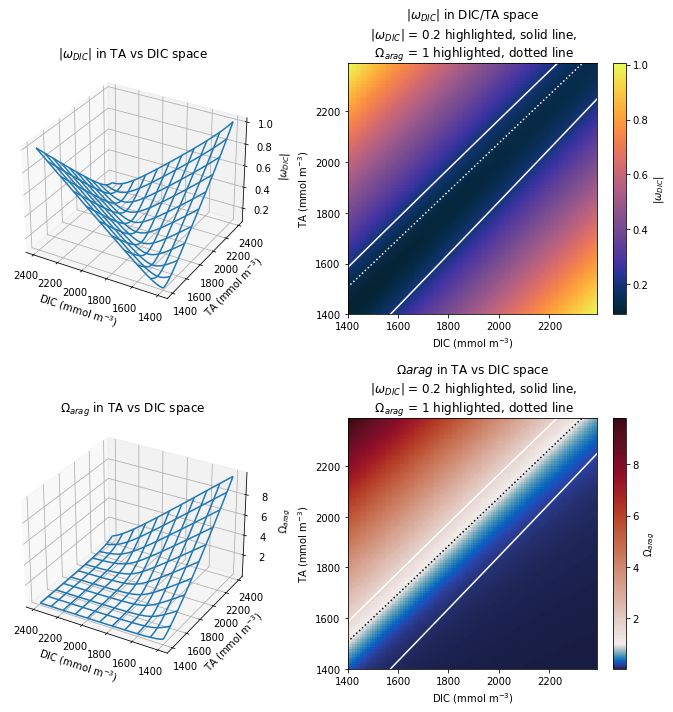

In [152]:
omega_lev = 0.2
tend = 100

fig = plt.figure(figsize=(10,10))

# Second subplot
ax = fig.add_subplot(2, 2, 3, projection='3d')

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]
X, Y = np.meshgrid(X, Y)

Z = OmegaAr_vTD[0:tend,0:tend]
surf = ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.set_zlabel('$\Omega_{arag}$')
ax.invert_yaxis()
ax.set_xlabel('DIC (mmol m$^{-3}$)')
ax.set_ylabel('TA (mmol m$^{-3}$)')
ax.set_title('$\Omega_{arag}$ in TA vs DIC space')# \n S = 30 psu, T = 10 $^{\circ}$ C')
# fig.colorbar(surf, shrink=0.5, aspect=5, label = '$\Omega_A$')

# First subplot
ax = fig.add_subplot(2, 2, 4)
w = ax.pcolormesh(X, Y,Z, \
                  norm=MidpointNormalize(midpoint=1.),
                  cmap = cm.balance
                 )
ax.set_xlabel('DIC (mmol m$^{-3}$)')
ax.set_ylabel('TA (mmol m$^{-3}$)')
ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'w')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], colors = 'k', linestyles = 'dotted')
ax.set_title('$\Omega{arag}$ in TA vs DIC space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{arag}$ = 1 highlighted, dotted line')

fig.colorbar(w, label = '$\Omega_{arag}$')

ax = fig.add_subplot(2, 2, 1, projection='3d')

# X = DIC_ar
# Y = TA_ar
# X, Y = np.meshgrid(X, Y)

Z = -omega_DIC_r[0:tend,0:tend]
surf = ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.set_zlabel('|$\omega_{DIC}$|')
ax.invert_yaxis()
ax.set_xlabel('DIC (mmol m$^{-3}$)')
ax.set_ylabel('TA (mmol m$^{-3}$)')
ax.set_title('|$\omega_{DIC}$| in TA vs DIC space')# \n S = 30 psu, T = 10 $^{\circ}$ C')
# fig.colorbar(surf, shrink=0.5, aspect=5, label = '$\Omega_A$')


# First subplot
ax = fig.add_subplot(2, 2, 2)
w = ax.pcolormesh(X, Y,Z, \
                  cmap = cm.thermal, alpha = 1,)
ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'w')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'w' )
ax.set_xlabel('DIC (mmol m$^{-3}$)')
ax.set_ylabel('TA (mmol m$^{-3}$)')
fig.colorbar(w, label = '|$\omega_{DIC}$|')
ax.set_title('|$\omega_{DIC}$| in DIC/TA space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{arag}$ = 1 highlighted, dotted line')
plt.tight_layout()

plt.show()


# Put it together

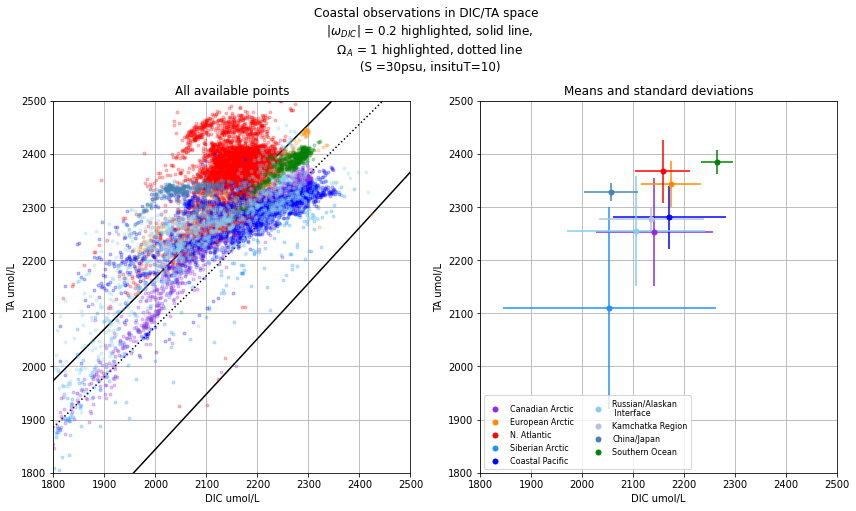

In [192]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(20*fact,12*fact))
ax = plt.subplot(1,2,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
            tALK[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)

ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')    
ax.set_title('All available points')

ax = plt.subplot(1,2,2)
fs = 8
tcol = 'black'
tlw = 4.5
ms = 10

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
            np.nanmean(tALK[filt_comp & (tGEO == geotag)]),\
           color = tcol, marker = '.', markersize = ms, \
            linestyle = '',\
           label = tnam, alpha = 1)
    ax.errorbar(np.nanmean(tDIC[filt_comp & (tGEO == geotag)]),\
                np.nanmean(tALK[filt_comp & (tGEO == geotag)]), \
                xerr = np.nanstd(tDIC[filt_comp & (tGEO == geotag)]),\
                yerr = np.nanstd(tALK[filt_comp & (tGEO == geotag)]),
                fmt="o",
               color = tcol, marker = '.', linestyle = '',\
            alpha = 1)
ax.legend(ncol = 2, loc = 'best', fontsize = 8)
ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])
#ax.contour(X, Y, -omega_DIC_r, levels=[omega_lev], colors = 'k')
#ax.contour(X, Y, OmegaAr_vTD, levels=[1], linestyles = 'dotted', colors = 'k' )
plt.suptitle('Coastal observations in DIC/TA space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line \n (S =30psu, insituT=10)')


plt.tight_layout()

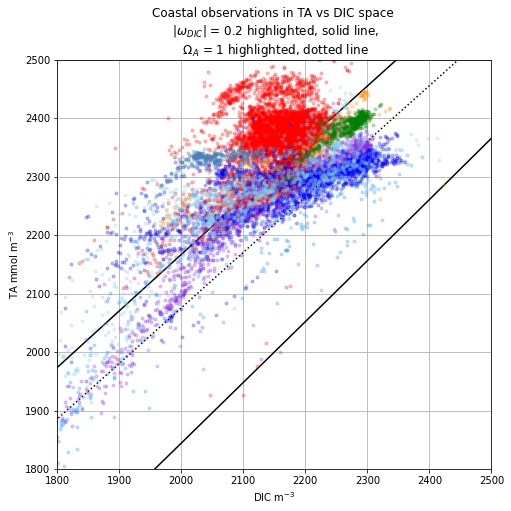

In [154]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))
ax = plt.subplot(1,1,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(1,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    ax.plot(tDIC[filt_comp & (tGEO == geotag)],\
            tALK[filt_comp & (tGEO == geotag)],\
           color = tcol, marker = '.', linestyle = '',\
           label = tnam, alpha = talph)

ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC m$^{-3}$')    
ax.set_title('Coastal observations in TA vs DIC space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line')




plt.tight_layout()

No handles with labels found to put in legend.


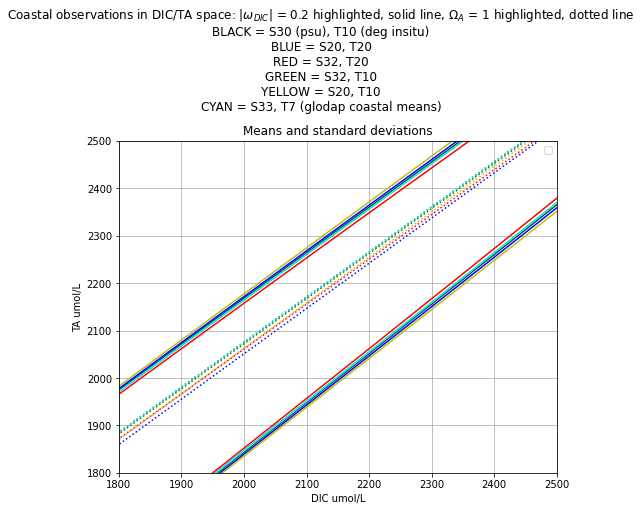

In [155]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))
ax = plt.subplot(1,1,1)
fs = 8
tcol = 'black'
tlw = 4.5

fs = 8
tcol = 'black'
tlw = 4.5
ms = 10

ax.set_ylabel('TA umol/L')
ax.set_xlabel('DIC umol/L')
ax.set_title('Means and standard deviations')
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])
CS = ax.contour(X, Y, -omega_DIC_r, \
           levels=[omega_lev], colors = 'k',\
          label = 'S=30 psu, T = 10 $\deg$C')
ax.contour(X, Y, OmegaAr_vTD, levels=[1],\
           linestyles = 'dotted', colors = 'k',\
          )
# plt.clabel(CS, inline=1, fontsize=10)
# plt.title('Simplest default with labels')

# labels = ['line1', 'line2','line3','line4',
#            'line5', 'line6']
# for i in range(len(labels)):
#     CS.collections[i].set_label(labels[i])

ax.contour(X, Y, -omega_DIC_r_S20_T20, \
           levels=[omega_lev], colors = 'b')
ax.contour(X, Y, OmegaA_A_r_S20_T20, levels=[1],\
           linestyles = 'dotted', colors = 'b' )

ax.contour(X, Y, -omega_DIC_r_S32_T20, \
           levels=[omega_lev], colors = 'r')
ax.contour(X, Y, OmegaA_A_r_S32_T20, levels=[1],\
           linestyles = 'dotted', colors = 'r' )

ax.contour(X, Y, -omega_DIC_r_S32_T10, \
           levels=[omega_lev], colors = 'g')
ax.contour(X, Y, OmegaA_A_r_S32_T10, levels=[1],\
           linestyles = 'dotted', colors = 'g' )

ax.contour(X, Y, -omega_DIC_r_S20_T10, \
           levels=[omega_lev], colors = 'y')
ax.contour(X, Y, OmegaA_A_r_S20_T10, levels=[1],\
           linestyles = 'dotted', colors = 'y' )

ax.contour(X, Y, -omega_DIC_r_S33_T7, \
           levels=[omega_lev], colors = 'cyan', lw =5 )
ax.contour(X, Y, OmegaA_A_r_S33_T7, levels=[1],\
           linestyles = 'dotted', colors = 'cyan', lw =5 )
plt.legend()
lin1 = 'Coastal observations in DIC/TA space: |$\omega_{DIC}$| = 0.2 highlighted, solid line, $\Omega_{A}$ = 1 highlighted, dotted line'
lin2 = 'BLACK = S30 (psu), T10 (deg insitu)'
lin3 = 'BLUE = S20, T20'
lin4 = 'RED = S32, T20'
lin5 = 'GREEN = S32, T10'
lin6 = 'YELLOW = S20, T10'
lin7 = 'CYAN = S33, T7 (glodap coastal means)'
plt.suptitle(f'{lin1}\n{lin2}\n{lin3}\n{lin4}\n{lin5}\n{lin6}\n{lin7}')
    

plt.tight_layout()

In [156]:
print('mean temp in gloadap coastal:')
print(np.nanmean(tTEMP[filt_comp]))
print('std dev temp in gloadap coastal:')
print(np.nanstd(tTEMP[filt_comp]))
print('mean sal in gloadap coastal:')
print(np.nanmean(tSAL[filt_comp]))
print('std dev sal in gloadap coastal:')
print(np.nanstd(tSAL[filt_comp]))
# print(f'std dev temp in gloadap coastal:{np.nanstd(tTEMP[filt_comp]}')



mean temp in gloadap coastal:
6.624162615122712
std dev temp in gloadap coastal:
6.964604801299382
mean sal in gloadap coastal:
33.47744407717406
std dev sal in gloadap coastal:
2.0737094619835914


# Kernel density estimate

In [157]:
data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 1000)

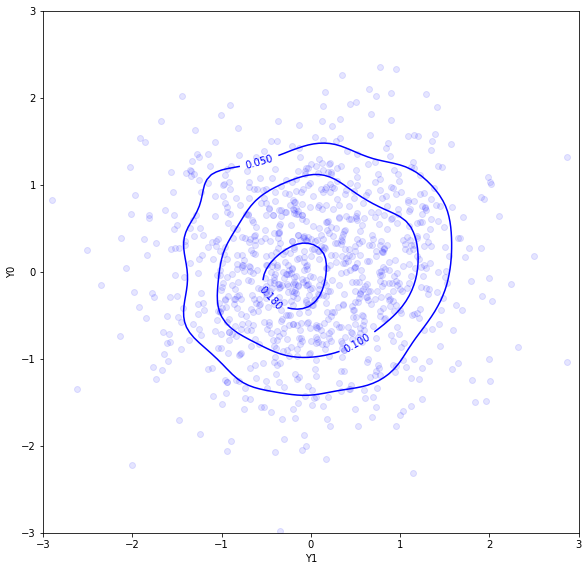

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

fact = 0.8

x = data[:, 0]
y = data[:, 1]
xmin, xmax = -3, 3
ymin, ymax = -3, 3

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(12*fact,12*fact)) 
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.scatter(x,y, color = 'b', alpha = 0.1)
# Contourf plot
#cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, levels = [0.05,0.1,0.18], colors='b')
#ax.contour(xx, yy, f, levels = [0.1], colors='r')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

plt.show()

In [159]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

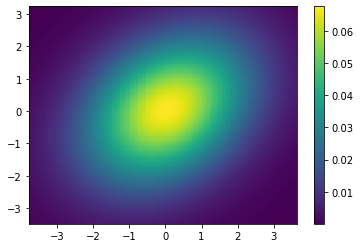

In [160]:
import numpy as np
import matplotlib.pyplot as plt

m1 = np.random.normal(size=1000)
m2 = np.random.normal(scale=0.5, size=1000)

x, y = m1 + m2, m1 - m2

xx, yy, zz = kde2D(x, y, 1.10)

w = plt.pcolormesh(xx, yy, zz)
#plt.scatter(x, y, s=2, facecolor='white')

plt.colorbar(w)

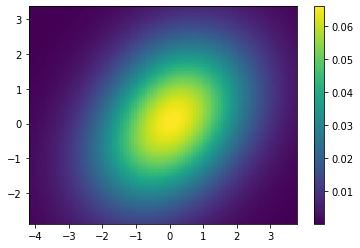

In [161]:
import numpy as np
import matplotlib.pyplot as plt

m1 = np.random.normal(size=1000)
m2 = np.random.normal(scale=0.5, size=1000)

x, y = m1 + m2, m1 - m2

xx, yy, zz = kde2D(x, y, 1.10)

w = plt.pcolormesh(xx, yy, zz)
#plt.scatter(x, y, s=2, facecolor='white')

plt.colorbar(w)

TypeError: cannot unpack non-iterable AxesSubplot object

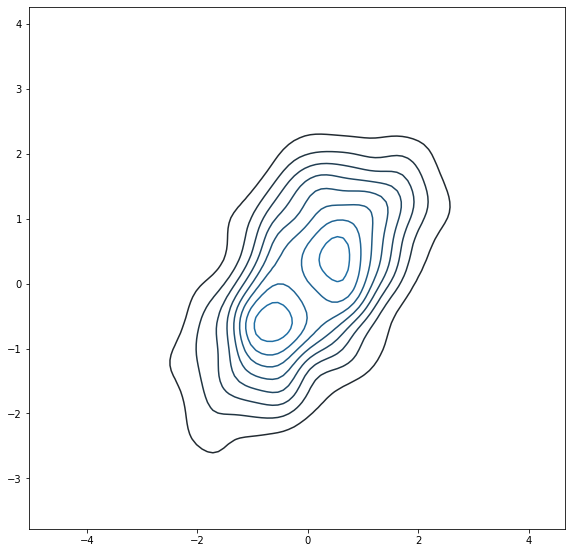

In [162]:
import seaborn as sns

fig = plt.figure(figsize=(12*fact,12*fact)) 
ax3 = fig.gca()

q, cs = sns.kdeplot(x, y)
# label the contours
ax3.clabel(cs, cs.levels[::1], c = 'r', inline=True)

## https://stackoverflow.com/questions/64362044/what-does-levels-mean-in-seaborn-kde-plot

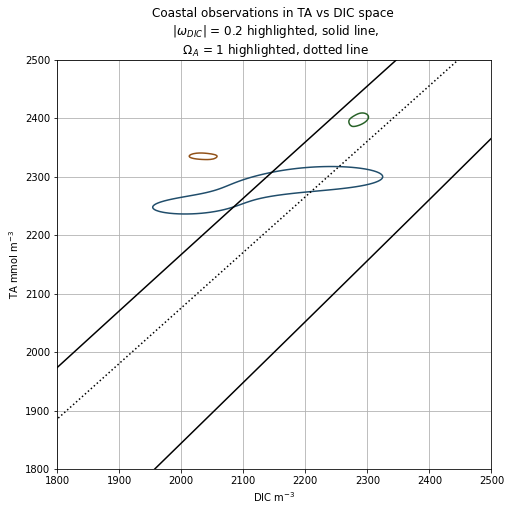

In [166]:
talph = 0.25
fact = 0.6
fig = plt.figure(figsize=(12*fact,12*fact))
ax = plt.subplot(1,1,1)
fs = 8
tcol = 'black'
tlw = 4.5
tend = 130

X = DIC_ar[0:tend]
Y = TA_ar[0:tend]

for i in range(7,len(list_places)):
    geotag = (PLACES_withdat[list_places[i]]['geodat'])
    tcol = (PLACES_withdat[list_places[i]]['colour'])
    tnam = (PLACES_withdat[list_places[i]]['name'])
    #print('(╯°□°）╯︵ ┻━┻')
    x = tDIC[filt_comp & (tGEO == geotag)]
    y = tALK[filt_comp & (tGEO == geotag)]
#     ax.plot(x,y,\
#            color = tcol, marker = '.', linestyle = '',\
#            label = tnam, alpha = talph)
    
    sns.kdeplot(x, y, hue = 'r', levels=1)

ax.contour(X, Y, -omega_DIC_r[0:tend,0:tend], levels=[omega_lev], colors = 'k')
ax.contour(X, Y, OmegaAr_vTD[0:tend,0:tend], levels=[1], linestyles = 'dotted', colors = 'k' )
ax.grid()
ax.set_xlim([1800,2500])
ax.set_ylim([1800,2500])

ax.set_ylabel('TA mmol m$^{-3}$')
ax.set_xlabel('DIC m$^{-3}$')    
ax.set_title('Coastal observations in TA vs DIC space \n |$\omega_{DIC}$| = 0.2 highlighted, solid line, \n $\Omega_{A}$ = 1 highlighted, dotted line')




plt.tight_layout()

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)


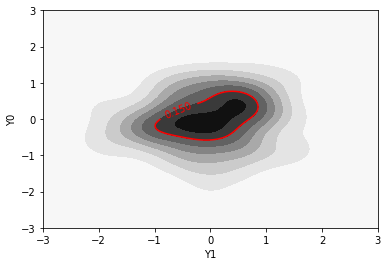

In [188]:
x = data[:, 0]
y = data[:, 1]
xmin, xmax = -3, 3
ymin, ymax = -3, 3

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = pl.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Greys')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, levels = [0.15], colors='r', linewidth = 7)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

pl.show()

(<AxesSubplot:>, <matplotlib.contour.QuadContourSet at 0x7f5ca281ff10>)

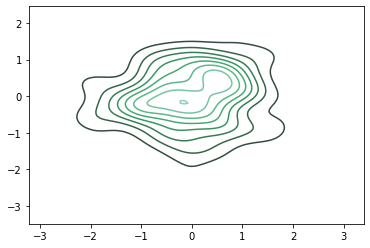

In [191]:
sns.kdeplot(x, y, hue = 'r', levels=8, thres = 0.05)

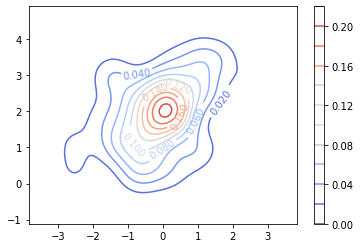

In [186]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(10)
import seaborn as sns
import seaborn.distributions as sd
from seaborn.palettes import color_palette, blend_palette
from six import string_types


def _bivariate_kdeplot(x, y, filled, fill_lowest,
                       kernel, bw, gridsize, cut, clip,
                       axlabel, cbar, cbar_ax, cbar_kws, ax, **kwargs):
    """Plot a joint KDE estimate as a bivariate contour plot."""
    # Determine the clipping
    if clip is None:
        clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
    elif np.ndim(clip) == 1:
        clip = [clip, clip]

    # Calculate the KDE
    if sd._has_statsmodels:
        xx, yy, z = sd._statsmodels_bivariate_kde(x, y, bw, gridsize, cut, clip)
    else:
        xx, yy, z = sd._scipy_bivariate_kde(x, y, bw, gridsize, cut, clip)

    # Plot the contours
    n_levels = kwargs.pop("n_levels", 10)
    cmap = kwargs.get("cmap", "BuGn" if filled else "BuGn_d")
    if isinstance(cmap, string_types):
        if cmap.endswith("_d"):
            pal = ["#333333"]
            pal.extend(color_palette(cmap.replace("_d", "_r"), 2))
            cmap = blend_palette(pal, as_cmap=True)
        else:
            cmap = plt.cm.get_cmap(cmap)

    kwargs["cmap"] = cmap
    contour_func = ax.contourf if filled else ax.contour
    cset = contour_func(xx, yy, z, n_levels, **kwargs)
    if filled and not fill_lowest:
        cset.collections[0].set_alpha(0)
    kwargs["n_levels"] = n_levels

    if cbar:
        cbar_kws = {} if cbar_kws is None else cbar_kws
        ax.figure.colorbar(cset, cbar_ax, ax, **cbar_kws)

    # Label the axes
    if hasattr(x, "name") and axlabel:
        ax.set_xlabel(x.name)
    if hasattr(y, "name") and axlabel:
        ax.set_ylabel(y.name)

    return ax, cset

# monkey patching
sd._bivariate_kdeplot = _bivariate_kdeplot

# some data
mean, cov = [0, 2], [(1, .5), (.5, 1)]
x, y = np.random.multivariate_normal(mean, cov, size=50).T

# plot
fig, ax = plt.subplots()
_, cs = sns.kdeplot(x, y, ax=ax, cmap="coolwarm")
# label the contours
plt.clabel(cs, cs.levels, inline=True)
# add a colorbar
fig.colorbar(cs)

plt.show()